In [2]:
!pip install -q utils
!pip install -q mxnet
!pip install optuna

     |████████████████████████████████| 68.7MB 59kB/s 
     |████████████████████████████████| 153kB 3.5MB/s 
     |████████████████████████████████| 1.1MB 56.8MB/s 
     |████████████████████████████████| 81kB 11.4MB/s 
     |████████████████████████████████| 81kB 12.1MB/s 
     |████████████████████████████████| 51kB 8.1MB/s 
     |████████████████████████████████| 61kB 8.8MB/s 
     |████████████████████████████████| 112kB 55.3MB/s 
  Created wheel for optuna: filename=optuna-1.2.0-cp36-none-any.whl size=204611 sha256=c04305b9bbca780876fe0149fc67840cf27ae1fee23b4cae4a912d3b2b889c3e
  Stored in directory: /root/.cache/pip/wheels/74/51/a0/d51cb5716dafc9f32af6559cffe42d535d3743f4eac7c98712
  Created wheel for alembic: filename=alembic-1.4.1-py2.py3-none-any.whl size=158154 sha256=a12cb8497b554d9da595ae4a81b26c9bd3613110db1be8fede057ff46e747fa2
  Stored in directory: /root/.cache/pip/wheels/84/07/f7/12f7370ca47a66030c2edeedcc23dec26ea0ac22dcb4c4a0f3
  Created wheel for pyperclip: filena

In [0]:
from utils import *

import time
import numpy as np

from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA


import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn import decomposition
pca = decomposition.PCA()

In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
context = mx.cpu(); model_ctx=mx.cpu()
mx.random.seed(1719)

In [0]:
def parser(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

In [8]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/Karunanidhimishra/dataset/master/gs.csv \
    -O /tmp/gs.csv

--2020-03-15 09:50:48--  https://raw.githubusercontent.com/Karunanidhimishra/dataset/master/gs.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 231285 (226K) [text/plain]
Saving to: ‘/tmp/gs.csv’

/tmp/gs.csv         100%[===================>] 225.86K  --.-KB/s    in 0.04s   

2020-03-15 09:50:49 (5.43 MB/s) - ‘/tmp/gs.csv’ saved [231285/231285]



In [0]:
dataset_ex_df = pd.read_csv('/tmp/gs.csv', header=0, parse_dates=[0], date_parser=parser)

from google.colab import drive
drive.mount('/content/drive')

In [10]:
dataset_ex_df[['Date', 'Close','Open','High','Low','Volume']].head(10)

,Date,Close,Open,High,Low,Volume
0,1999-05-04,62.659,67.665,68.780,62.329,24472946
1,1999-05-05,61.547,62.213,62.213,58.991,8295140
2,1999-05-06,60.488,60.542,61.773,59.712,3185852
3,1999-05-07,65.998,60.488,66.671,59.429,5331091
4,1999-05-10,62.941,65.331,65.441,62.549,2839054
5,1999-05-11,62.888,62.329,63.389,61.885,2017182
6,1999-05-12,65.441,63.216,66.671,61.547,2915697
7,1999-05-13,65.166,65.222,67.000,64.555,1253094
8,1999-05-14,62.497,63.444,64.329,61.491,2256860
9,1999-05-17,61.098,61.547,62.549,60.542,2275059


In [12]:
print('There are {} number of days in the dataset.'.format(dataset_ex_df.shape[0]))

There are 4661 number of days in the dataset.


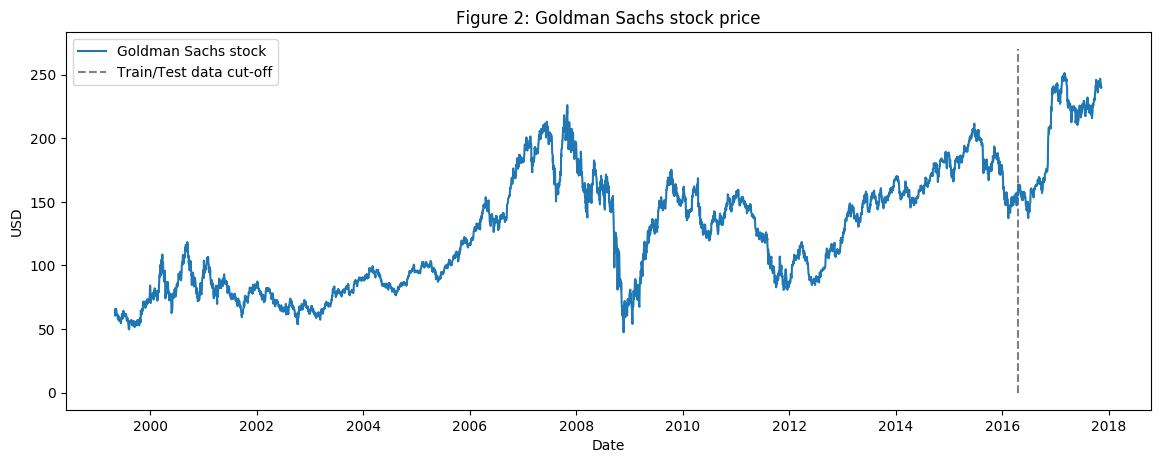

In [13]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(dataset_ex_df['Date'], dataset_ex_df['Close'], label='Goldman Sachs stock')
plt.vlines(datetime.date(2016,4, 20), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 2: Goldman Sachs stock price')
plt.legend()
plt.show()

In [14]:
num_training_days = int(dataset_ex_df.shape[0]*.8)
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days, \
                                                                    dataset_ex_df.shape[0]-num_training_days))

Number of training days: 3728. Number of test days: 933.


In [0]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Close'].rolling(window=7).mean()
    dataset['ma21'] = dataset['Close'].rolling(window=21).mean()
    dataset['20std'] = dataset['Close'].rolling(window=20).std()
    
    # Create MACD
    dataset['26ema'] = dataset['Close'].ewm(span=26).mean()
    dataset['12ema'] = dataset['Close'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    #dataset['20sd'] = pd.stats.moments.rolling_std(dataset['Close'],20)
    dataset['upper_band'] = dataset['ma21'] + (dataset['20std']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20std']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset['Close']-1
   
    return dataset

In [0]:
dataset_TI_df = get_technical_indicators(dataset_ex_df[['Close']])

In [18]:
dataset_TI_df.head(22)

,Close,ma7,ma21,20std,26ema,12ema,MACD,upper_band,lower_band,ema,momentum
0,62.659,NaN,NaN,NaN,62.659000,62.659000,0.000000,NaN,NaN,62.659000,61.659
1,61.547,NaN,NaN,NaN,62.081615,62.056667,-0.024949,NaN,NaN,61.825000,60.547
2,60.488,NaN,NaN,NaN,61.509045,61.444416,-0.064629,NaN,NaN,60.899385,59.488
3,65.998,NaN,NaN,NaN,62.763961,62.881804,0.117844,NaN,NaN,64.340950,64.998
4,62.941,NaN,NaN,NaN,62.805017,62.897888,0.092871,NaN,NaN,63.403793,61.941
5,62.888,NaN,NaN,NaN,62.821638,62.895484,0.073847,NaN,NaN,63.059459,61.888
6,65.441,63.137429,NaN,NaN,63.287478,63.463507,0.176030,NaN,NaN,64.647879,64.441
7,65.166,63.495571,NaN,NaN,63.590154,63.818791,0.228637,NaN,NaN,64.993346,64.166
8,62.497,63.631286,NaN,NaN,63.428125,63.557294,0.129169,NaN,NaN,63.329031,61.497
9,61.098,63.718429,NaN,NaN,63.106590,63.091259,-0.015331,NaN,NaN,61.841652,60.098


In [0]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Close'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

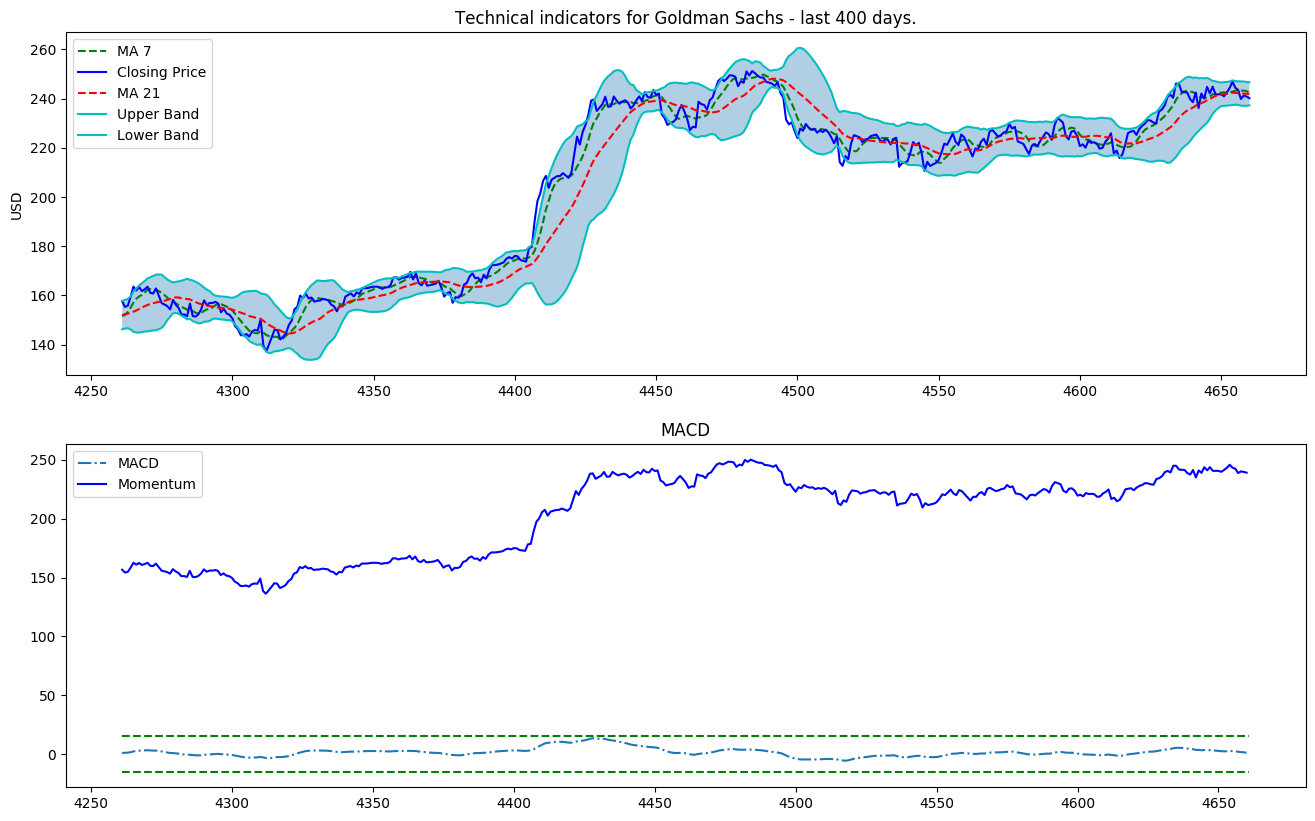

In [20]:
plot_technical_indicators(dataset_TI_df, 400)

In [0]:
# sample_data=dataset_TI_df.fillna(0)
# standardized_data = StandardScaler().fit_transform(sample_data)
# standardized_data = pd.DataFrame(data=standardized_data,columns=sample_data.columns)
# standardized_data.head()

# pca.n_components = standardized_data.shape[1]
# pca_data = pca.fit_transform(standardized_data)
# data_sample=pd.DataFrame(data=pca_data,columns=standardized_data.columns)
# data_sample.head()
# percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_);
# cum_var_explained = np.cumsum(percentage_var_explained)

# # Plot the PCA spectrum
# plt.figure(1, figsize=(6, 4))

# plt.clf()
# plt.plot(cum_var_explained, linewidth=2)
# plt.axis('tight')
# plt.grid()
# plt.xlabel('n_components')
# plt.ylabel('Cumulative_explained_variance')
# plt.show()

# pca.n_components =standardized_data.shape[1]
# pca_data = pca.fit_transform(standardized_data)
# data_sample=pd.DataFrame(data=pca_data,columns=standardized_data.columns)
# data_sample.head()

# fig = plt.figure(figsize=(8,8))
# plt.xticks(rotation='vertical')
# plt.bar([i for i in range(len(data_sample.columns))], xgbModel.feature_importances_.tolist(), tick_label=data_sample.columns)
# plt.title('Figure 6: Feature importance of the technical indicators.')
# plt.show()


In [0]:
data_FT = dataset_ex_df[['Date', 'Close']]

In [0]:
close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

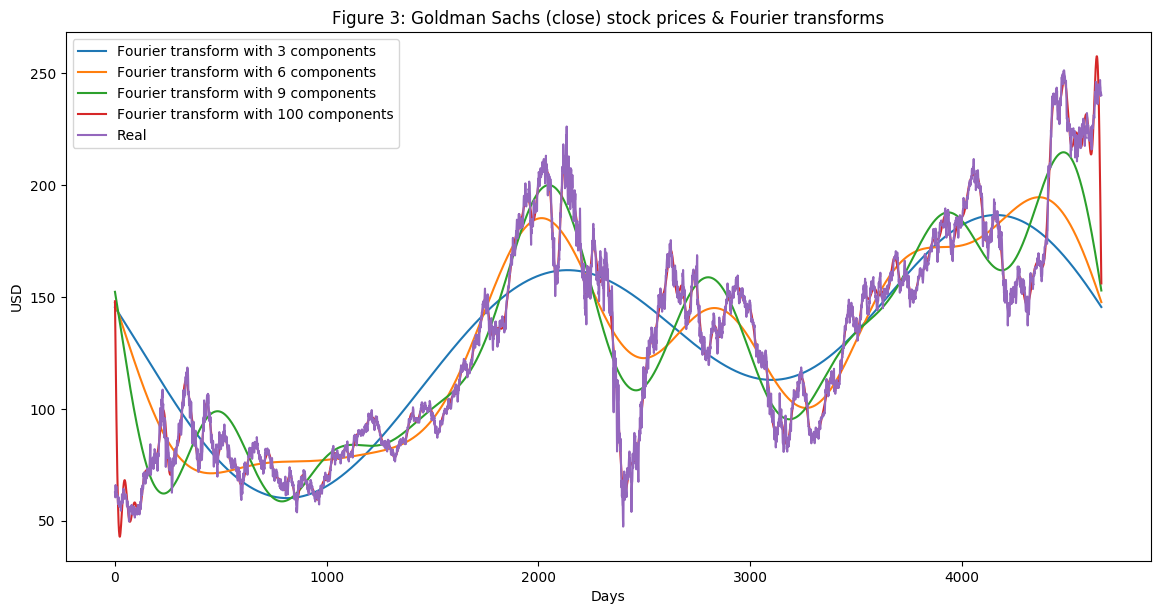

In [23]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data_FT['Close'],  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: Goldman Sachs (close) stock prices & Fourier transforms')
plt.legend()
plt.show()

In [24]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = data_FT['Close']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4660
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -11234.027
Method:                       css-mle   S.D. of innovations              2.696
Date:                Sun, 15 Mar 2020   AIC                          22482.055
Time:                        09:58:45   BIC                          22527.182
Sample:                             1   HQIC                         22497.928
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0382      0.035      1.088      0.277      -0.031       0.107
ar.L1.D.Close    -0.0501      0.015     -3.424      0.001      -0.079      -0.021
ar.L2.D.Close    -0.0195      0.015     

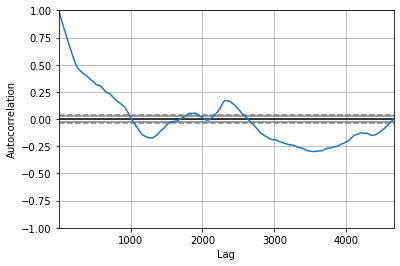

<Figure size 800x560 with 0 Axes>

In [25]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show() 

In [0]:
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

In [27]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 5.839


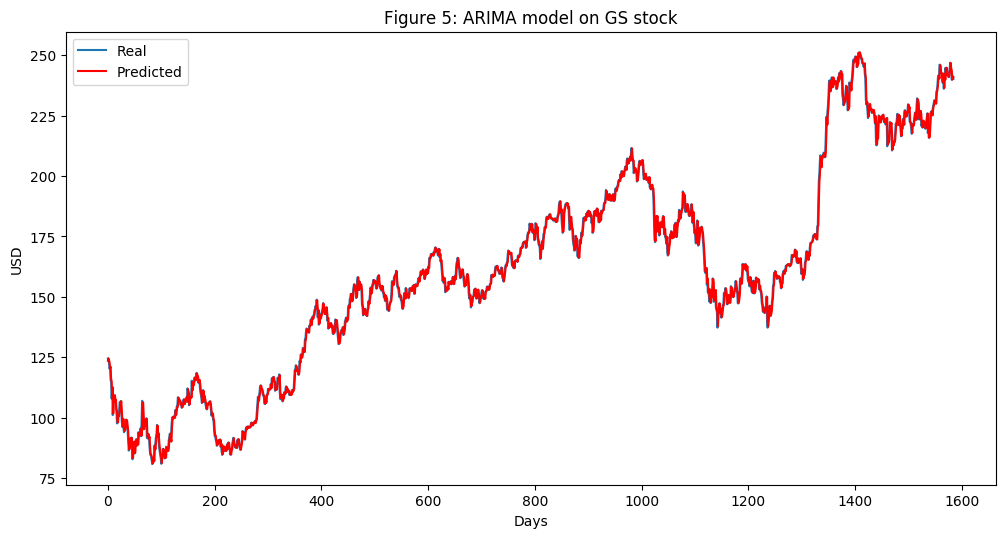

In [28]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, label='Real')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: ARIMA model on GS stock')
plt.legend()
plt.show()

In [0]:
def get_feature_importance_data(data_income):
    data = data_income.copy()
    y = data['Close']
    X = data.iloc[:, 1:]
    
    train_samples = int(X.shape[0] * 0.65)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

Feature importance with XGBoost

In [0]:
# Get training and test data
sample_data=dataset_TI_df.fillna(0)
standardized_data = StandardScaler().fit_transform(sample_data)
standardized_data = pd.DataFrame(data=standardized_data,columns=sample_data.columns)
#(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(standardized_data)


In [0]:
def opt(trial):
    #param_list
    n_estimators = trial.suggest_int('n_estimators', 0, 1000)
    optimizer = trial.suggest_categorical('optimizer', ['MomentumSGD', 'Adam'])
    gamma=trial.suggest_int('gamma', 0, 5)
    eval_metric=trial.suggest_categorical('eval_metric',['rmse'])
    max_depth = trial.suggest_int('max_depth', 1, 20)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 20)
    learning_rate=trial.suggest_loguniform('learning_rate',0.005,0.5)
    scale_pos_weight = trial.suggest_int('scale_pos_weight', 1, 100)
    subsample = trial.suggest_discrete_uniform('subsample', 0.5, 0.9, 0.1)
    colsample_bytree = trial.suggest_discrete_uniform('colsample_bytree', 0.5, 0.9, 0.1)
     
    (X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(standardized_data) 
    regressor = xgb.XGBRegressor(gamma=gamma,n_estimators=150,colsample_bytree=colsample_bytree,learning_rate=learning_rate,optimizer=optimizer)
    regressor.fit(X_train_FI, y_train_FI)
    tuna_pred_test = regressor.predict(X_test_FI)
    return regressor.score(X_test_FI, y_test_FI)

[12:22:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:05,576] Finished trial#0 resulted in value: 0.7160115441012159. Current best value is 0.7160115441012159 with parameters: {'n_estimators': 151, 'optimizer': 'Adam', 'gamma': 5, 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 3, 'learning_rate': 0.006224214587267605, 'scale_pos_weight': 87, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:05,984] Finished trial#1 resulted in value: 0.7769041661861197. Current best value is 0.7160115441012159 with parameters: {'n_estimators': 151, 'optimizer': 'Adam', 'gamma': 5, 'eval_metric': 'rmse', 'max_depth': 10, 'min_child_weight': 3, 'learning_rate': 0.006224214587267605, 'scale_pos_weight': 87, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:06,385] Finished trial#2 resulted in value: 0.6965683446505244. Current best value is 0.6965683446505244 with parameters: {'n_estimators': 809, 'optimizer': 'MomentumSGD', 'gamma': 0, 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 5, 'learning_rate': 0.005640164747342607, 'scale_pos_weight': 44, 'subsample': 0.9, 'colsample_bytree': 0.7}.


[12:22:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:06,734] Finished trial#3 resulted in value: 0.9075574220440702. Current best value is 0.6965683446505244 with parameters: {'n_estimators': 809, 'optimizer': 'MomentumSGD', 'gamma': 0, 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 5, 'learning_rate': 0.005640164747342607, 'scale_pos_weight': 44, 'subsample': 0.9, 'colsample_bytree': 0.7}.


[12:22:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:07,148] Finished trial#4 resulted in value: 0.9083592656415649. Current best value is 0.6965683446505244 with parameters: {'n_estimators': 809, 'optimizer': 'MomentumSGD', 'gamma': 0, 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 5, 'learning_rate': 0.005640164747342607, 'scale_pos_weight': 44, 'subsample': 0.9, 'colsample_bytree': 0.7}.


[12:22:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:07,499] Finished trial#5 resulted in value: 0.8981722311822279. Current best value is 0.6965683446505244 with parameters: {'n_estimators': 809, 'optimizer': 'MomentumSGD', 'gamma': 0, 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 5, 'learning_rate': 0.005640164747342607, 'scale_pos_weight': 44, 'subsample': 0.9, 'colsample_bytree': 0.7}.


[12:22:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:07,913] Finished trial#6 resulted in value: 0.9341309513962224. Current best value is 0.6965683446505244 with parameters: {'n_estimators': 809, 'optimizer': 'MomentumSGD', 'gamma': 0, 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 5, 'learning_rate': 0.005640164747342607, 'scale_pos_weight': 44, 'subsample': 0.9, 'colsample_bytree': 0.7}.


[12:22:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:08,265] Finished trial#7 resulted in value: 0.898948120250723. Current best value is 0.6965683446505244 with parameters: {'n_estimators': 809, 'optimizer': 'MomentumSGD', 'gamma': 0, 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 5, 'learning_rate': 0.005640164747342607, 'scale_pos_weight': 44, 'subsample': 0.9, 'colsample_bytree': 0.7}.


[12:22:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:08,625] Finished trial#8 resulted in value: 0.9304320272180604. Current best value is 0.6965683446505244 with parameters: {'n_estimators': 809, 'optimizer': 'MomentumSGD', 'gamma': 0, 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 5, 'learning_rate': 0.005640164747342607, 'scale_pos_weight': 44, 'subsample': 0.9, 'colsample_bytree': 0.7}.


[12:22:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:09,060] Finished trial#9 resulted in value: 0.8443580320119947. Current best value is 0.6965683446505244 with parameters: {'n_estimators': 809, 'optimizer': 'MomentumSGD', 'gamma': 0, 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 5, 'learning_rate': 0.005640164747342607, 'scale_pos_weight': 44, 'subsample': 0.9, 'colsample_bytree': 0.7}.


[12:22:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:09,488] Finished trial#10 resulted in value: 0.9572398254179549. Current best value is 0.6965683446505244 with parameters: {'n_estimators': 809, 'optimizer': 'MomentumSGD', 'gamma': 0, 'eval_metric': 'rmse', 'max_depth': 9, 'min_child_weight': 5, 'learning_rate': 0.005640164747342607, 'scale_pos_weight': 44, 'subsample': 0.9, 'colsample_bytree': 0.7}.


[12:22:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:09,891] Finished trial#11 resulted in value: 0.6914930902222438. Current best value is 0.6914930902222438 with parameters: {'n_estimators': 29, 'optimizer': 'MomentumSGD', 'gamma': 0, 'eval_metric': 'rmse', 'max_depth': 11, 'min_child_weight': 2, 'learning_rate': 0.005566421224883436, 'scale_pos_weight': 98, 'subsample': 0.7, 'colsample_bytree': 0.6}.


[12:22:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:10,299] Finished trial#12 resulted in value: 0.9473226943275381. Current best value is 0.6914930902222438 with parameters: {'n_estimators': 29, 'optimizer': 'MomentumSGD', 'gamma': 0, 'eval_metric': 'rmse', 'max_depth': 11, 'min_child_weight': 2, 'learning_rate': 0.005566421224883436, 'scale_pos_weight': 98, 'subsample': 0.7, 'colsample_bytree': 0.6}.


[12:22:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:10,704] Finished trial#13 resulted in value: 0.6610027297433247. Current best value is 0.6610027297433247 with parameters: {'n_estimators': 987, 'optimizer': 'MomentumSGD', 'gamma': 1, 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 6, 'learning_rate': 0.005084790968215222, 'scale_pos_weight': 28, 'subsample': 0.8, 'colsample_bytree': 0.6}.


[12:22:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:11,119] Finished trial#14 resulted in value: 0.9009155611548172. Current best value is 0.6610027297433247 with parameters: {'n_estimators': 987, 'optimizer': 'MomentumSGD', 'gamma': 1, 'eval_metric': 'rmse', 'max_depth': 6, 'min_child_weight': 6, 'learning_rate': 0.005084790968215222, 'scale_pos_weight': 28, 'subsample': 0.8, 'colsample_bytree': 0.6}.


[12:22:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:11,531] Finished trial#15 resulted in value: 0.6565729830893499. Current best value is 0.6565729830893499 with parameters: {'n_estimators': 981, 'optimizer': 'MomentumSGD', 'gamma': 2, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005025117620533426, 'scale_pos_weight': 28, 'subsample': 0.7, 'colsample_bytree': 0.6}.


[12:22:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:11,929] Finished trial#16 resulted in value: 0.9200238109539387. Current best value is 0.6565729830893499 with parameters: {'n_estimators': 981, 'optimizer': 'MomentumSGD', 'gamma': 2, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005025117620533426, 'scale_pos_weight': 28, 'subsample': 0.7, 'colsample_bytree': 0.6}.


[12:22:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:12,401] Finished trial#17 resulted in value: 0.858332234539377. Current best value is 0.6565729830893499 with parameters: {'n_estimators': 981, 'optimizer': 'MomentumSGD', 'gamma': 2, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005025117620533426, 'scale_pos_weight': 28, 'subsample': 0.7, 'colsample_bytree': 0.6}.


[12:22:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:12,801] Finished trial#18 resulted in value: 0.9194748975934733. Current best value is 0.6565729830893499 with parameters: {'n_estimators': 981, 'optimizer': 'MomentumSGD', 'gamma': 2, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005025117620533426, 'scale_pos_weight': 28, 'subsample': 0.7, 'colsample_bytree': 0.6}.


[12:22:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:13,218] Finished trial#19 resulted in value: 0.657611611106641. Current best value is 0.6565729830893499 with parameters: {'n_estimators': 981, 'optimizer': 'MomentumSGD', 'gamma': 2, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005025117620533426, 'scale_pos_weight': 28, 'subsample': 0.7, 'colsample_bytree': 0.6}.


[12:22:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:13,648] Finished trial#20 resulted in value: 0.8496273997731955. Current best value is 0.6565729830893499 with parameters: {'n_estimators': 981, 'optimizer': 'MomentumSGD', 'gamma': 2, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005025117620533426, 'scale_pos_weight': 28, 'subsample': 0.7, 'colsample_bytree': 0.6}.


[12:22:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:14,053] Finished trial#21 resulted in value: 0.6576679710874413. Current best value is 0.6565729830893499 with parameters: {'n_estimators': 981, 'optimizer': 'MomentumSGD', 'gamma': 2, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005025117620533426, 'scale_pos_weight': 28, 'subsample': 0.7, 'colsample_bytree': 0.6}.


[12:22:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:14,469] Finished trial#22 resulted in value: 0.7855270694236222. Current best value is 0.6565729830893499 with parameters: {'n_estimators': 981, 'optimizer': 'MomentumSGD', 'gamma': 2, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005025117620533426, 'scale_pos_weight': 28, 'subsample': 0.7, 'colsample_bytree': 0.6}.


[12:22:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:14,878] Finished trial#23 resulted in value: 0.9059452921322543. Current best value is 0.6565729830893499 with parameters: {'n_estimators': 981, 'optimizer': 'MomentumSGD', 'gamma': 2, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005025117620533426, 'scale_pos_weight': 28, 'subsample': 0.7, 'colsample_bytree': 0.6}.


[12:22:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:15,312] Finished trial#24 resulted in value: 0.8140836974917711. Current best value is 0.6565729830893499 with parameters: {'n_estimators': 981, 'optimizer': 'MomentumSGD', 'gamma': 2, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005025117620533426, 'scale_pos_weight': 28, 'subsample': 0.7, 'colsample_bytree': 0.6}.


[12:22:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:15,730] Finished trial#25 resulted in value: 0.6691331011766288. Current best value is 0.6565729830893499 with parameters: {'n_estimators': 981, 'optimizer': 'MomentumSGD', 'gamma': 2, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005025117620533426, 'scale_pos_weight': 28, 'subsample': 0.7, 'colsample_bytree': 0.6}.


[12:22:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:16,115] Finished trial#26 resulted in value: 0.893307414821836. Current best value is 0.6565729830893499 with parameters: {'n_estimators': 981, 'optimizer': 'MomentumSGD', 'gamma': 2, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005025117620533426, 'scale_pos_weight': 28, 'subsample': 0.7, 'colsample_bytree': 0.6}.


[12:22:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:16,521] Finished trial#27 resulted in value: 0.6586853344144816. Current best value is 0.6565729830893499 with parameters: {'n_estimators': 981, 'optimizer': 'MomentumSGD', 'gamma': 2, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005025117620533426, 'scale_pos_weight': 28, 'subsample': 0.7, 'colsample_bytree': 0.6}.


[12:22:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:16,948] Finished trial#28 resulted in value: 0.7913502298488886. Current best value is 0.6565729830893499 with parameters: {'n_estimators': 981, 'optimizer': 'MomentumSGD', 'gamma': 2, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005025117620533426, 'scale_pos_weight': 28, 'subsample': 0.7, 'colsample_bytree': 0.6}.


[12:22:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:17,338] Finished trial#29 resulted in value: 0.6567506602374438. Current best value is 0.6565729830893499 with parameters: {'n_estimators': 981, 'optimizer': 'MomentumSGD', 'gamma': 2, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005025117620533426, 'scale_pos_weight': 28, 'subsample': 0.7, 'colsample_bytree': 0.6}.


[12:22:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:17,721] Finished trial#30 resulted in value: 0.9199156417951871. Current best value is 0.6565729830893499 with parameters: {'n_estimators': 981, 'optimizer': 'MomentumSGD', 'gamma': 2, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005025117620533426, 'scale_pos_weight': 28, 'subsample': 0.7, 'colsample_bytree': 0.6}.


[12:22:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:18,107] Finished trial#31 resulted in value: 0.6520068449806955. Current best value is 0.6520068449806955 with parameters: {'n_estimators': 585, 'optimizer': 'MomentumSGD', 'gamma': 4, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005028880500326778, 'scale_pos_weight': 87, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:18,498] Finished trial#32 resulted in value: 0.7505429708157022. Current best value is 0.6520068449806955 with parameters: {'n_estimators': 585, 'optimizer': 'MomentumSGD', 'gamma': 4, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005028880500326778, 'scale_pos_weight': 87, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:18,887] Finished trial#33 resulted in value: 0.738230333953227. Current best value is 0.6520068449806955 with parameters: {'n_estimators': 585, 'optimizer': 'MomentumSGD', 'gamma': 4, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005028880500326778, 'scale_pos_weight': 87, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:19,271] Finished trial#34 resulted in value: 0.8228580511417506. Current best value is 0.6520068449806955 with parameters: {'n_estimators': 585, 'optimizer': 'MomentumSGD', 'gamma': 4, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005028880500326778, 'scale_pos_weight': 87, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:19,668] Finished trial#35 resulted in value: 0.6551409787698363. Current best value is 0.6520068449806955 with parameters: {'n_estimators': 585, 'optimizer': 'MomentumSGD', 'gamma': 4, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005028880500326778, 'scale_pos_weight': 87, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:20,066] Finished trial#36 resulted in value: 0.7305672371300189. Current best value is 0.6520068449806955 with parameters: {'n_estimators': 585, 'optimizer': 'MomentumSGD', 'gamma': 4, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005028880500326778, 'scale_pos_weight': 87, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:20,451] Finished trial#37 resulted in value: 0.8704912257314696. Current best value is 0.6520068449806955 with parameters: {'n_estimators': 585, 'optimizer': 'MomentumSGD', 'gamma': 4, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005028880500326778, 'scale_pos_weight': 87, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:20,829] Finished trial#38 resulted in value: 0.9023289404199311. Current best value is 0.6520068449806955 with parameters: {'n_estimators': 585, 'optimizer': 'MomentumSGD', 'gamma': 4, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005028880500326778, 'scale_pos_weight': 87, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:21,220] Finished trial#39 resulted in value: 0.7289785340775017. Current best value is 0.6520068449806955 with parameters: {'n_estimators': 585, 'optimizer': 'MomentumSGD', 'gamma': 4, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005028880500326778, 'scale_pos_weight': 87, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:21,595] Finished trial#40 resulted in value: 0.9129237619832186. Current best value is 0.6520068449806955 with parameters: {'n_estimators': 585, 'optimizer': 'MomentumSGD', 'gamma': 4, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005028880500326778, 'scale_pos_weight': 87, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:21,989] Finished trial#41 resulted in value: 0.6800234220640192. Current best value is 0.6520068449806955 with parameters: {'n_estimators': 585, 'optimizer': 'MomentumSGD', 'gamma': 4, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005028880500326778, 'scale_pos_weight': 87, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:22,401] Finished trial#42 resulted in value: 0.8037164448398731. Current best value is 0.6520068449806955 with parameters: {'n_estimators': 585, 'optimizer': 'MomentumSGD', 'gamma': 4, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005028880500326778, 'scale_pos_weight': 87, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:22,798] Finished trial#43 resulted in value: 0.7151689588232479. Current best value is 0.6520068449806955 with parameters: {'n_estimators': 585, 'optimizer': 'MomentumSGD', 'gamma': 4, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005028880500326778, 'scale_pos_weight': 87, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:23,212] Finished trial#44 resulted in value: 0.6552356630745557. Current best value is 0.6520068449806955 with parameters: {'n_estimators': 585, 'optimizer': 'MomentumSGD', 'gamma': 4, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005028880500326778, 'scale_pos_weight': 87, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:23,647] Finished trial#45 resulted in value: 0.9102356549403545. Current best value is 0.6520068449806955 with parameters: {'n_estimators': 585, 'optimizer': 'MomentumSGD', 'gamma': 4, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005028880500326778, 'scale_pos_weight': 87, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:24,105] Finished trial#46 resulted in value: 0.8976687042439507. Current best value is 0.6520068449806955 with parameters: {'n_estimators': 585, 'optimizer': 'MomentumSGD', 'gamma': 4, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005028880500326778, 'scale_pos_weight': 87, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:24,497] Finished trial#47 resulted in value: 0.806848069820086. Current best value is 0.6520068449806955 with parameters: {'n_estimators': 585, 'optimizer': 'MomentumSGD', 'gamma': 4, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005028880500326778, 'scale_pos_weight': 87, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:24,908] Finished trial#48 resulted in value: 0.8595143997639783. Current best value is 0.6520068449806955 with parameters: {'n_estimators': 585, 'optimizer': 'MomentumSGD', 'gamma': 4, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005028880500326778, 'scale_pos_weight': 87, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:25,298] Finished trial#49 resulted in value: 0.9098872731166522. Current best value is 0.6520068449806955 with parameters: {'n_estimators': 585, 'optimizer': 'MomentumSGD', 'gamma': 4, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005028880500326778, 'scale_pos_weight': 87, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:25,711] Finished trial#50 resulted in value: 0.917382204002032. Current best value is 0.6520068449806955 with parameters: {'n_estimators': 585, 'optimizer': 'MomentumSGD', 'gamma': 4, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005028880500326778, 'scale_pos_weight': 87, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:26,152] Finished trial#51 resulted in value: 0.658980278431317. Current best value is 0.6520068449806955 with parameters: {'n_estimators': 585, 'optimizer': 'MomentumSGD', 'gamma': 4, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005028880500326778, 'scale_pos_weight': 87, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:26,595] Finished trial#52 resulted in value: 0.7190114892115265. Current best value is 0.6520068449806955 with parameters: {'n_estimators': 585, 'optimizer': 'MomentumSGD', 'gamma': 4, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005028880500326778, 'scale_pos_weight': 87, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:27,010] Finished trial#53 resulted in value: 0.6672907213162289. Current best value is 0.6520068449806955 with parameters: {'n_estimators': 585, 'optimizer': 'MomentumSGD', 'gamma': 4, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005028880500326778, 'scale_pos_weight': 87, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:27,427] Finished trial#54 resulted in value: 0.7661191267707705. Current best value is 0.6520068449806955 with parameters: {'n_estimators': 585, 'optimizer': 'MomentumSGD', 'gamma': 4, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005028880500326778, 'scale_pos_weight': 87, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:27,870] Finished trial#55 resulted in value: 0.8328597416229077. Current best value is 0.6520068449806955 with parameters: {'n_estimators': 585, 'optimizer': 'MomentumSGD', 'gamma': 4, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005028880500326778, 'scale_pos_weight': 87, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:28,288] Finished trial#56 resulted in value: 0.7109004451257117. Current best value is 0.6520068449806955 with parameters: {'n_estimators': 585, 'optimizer': 'MomentumSGD', 'gamma': 4, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005028880500326778, 'scale_pos_weight': 87, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:28,686] Finished trial#57 resulted in value: 0.6626985408638932. Current best value is 0.6520068449806955 with parameters: {'n_estimators': 585, 'optimizer': 'MomentumSGD', 'gamma': 4, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005028880500326778, 'scale_pos_weight': 87, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:29,108] Finished trial#58 resulted in value: 0.7798647018449913. Current best value is 0.6520068449806955 with parameters: {'n_estimators': 585, 'optimizer': 'MomentumSGD', 'gamma': 4, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005028880500326778, 'scale_pos_weight': 87, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:29,507] Finished trial#59 resulted in value: 0.8328451612292166. Current best value is 0.6520068449806955 with parameters: {'n_estimators': 585, 'optimizer': 'MomentumSGD', 'gamma': 4, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005028880500326778, 'scale_pos_weight': 87, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:29,929] Finished trial#60 resulted in value: 0.8859756358708628. Current best value is 0.6520068449806955 with parameters: {'n_estimators': 585, 'optimizer': 'MomentumSGD', 'gamma': 4, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005028880500326778, 'scale_pos_weight': 87, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:30,354] Finished trial#61 resulted in value: 0.6710816655543654. Current best value is 0.6520068449806955 with parameters: {'n_estimators': 585, 'optimizer': 'MomentumSGD', 'gamma': 4, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005028880500326778, 'scale_pos_weight': 87, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:30,777] Finished trial#62 resulted in value: 0.7259603267837289. Current best value is 0.6520068449806955 with parameters: {'n_estimators': 585, 'optimizer': 'MomentumSGD', 'gamma': 4, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005028880500326778, 'scale_pos_weight': 87, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:31,230] Finished trial#63 resulted in value: 0.665703647321507. Current best value is 0.6520068449806955 with parameters: {'n_estimators': 585, 'optimizer': 'MomentumSGD', 'gamma': 4, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005028880500326778, 'scale_pos_weight': 87, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:31,651] Finished trial#64 resulted in value: 0.7922403869961767. Current best value is 0.6520068449806955 with parameters: {'n_estimators': 585, 'optimizer': 'MomentumSGD', 'gamma': 4, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005028880500326778, 'scale_pos_weight': 87, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:32,146] Finished trial#65 resulted in value: 0.6995102481976001. Current best value is 0.6520068449806955 with parameters: {'n_estimators': 585, 'optimizer': 'MomentumSGD', 'gamma': 4, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005028880500326778, 'scale_pos_weight': 87, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:32,571] Finished trial#66 resulted in value: 0.6567956731956801. Current best value is 0.6520068449806955 with parameters: {'n_estimators': 585, 'optimizer': 'MomentumSGD', 'gamma': 4, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005028880500326778, 'scale_pos_weight': 87, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:32,979] Finished trial#67 resulted in value: 0.7521352746986814. Current best value is 0.6520068449806955 with parameters: {'n_estimators': 585, 'optimizer': 'MomentumSGD', 'gamma': 4, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005028880500326778, 'scale_pos_weight': 87, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:33,380] Finished trial#68 resulted in value: 0.803241903193134. Current best value is 0.6520068449806955 with parameters: {'n_estimators': 585, 'optimizer': 'MomentumSGD', 'gamma': 4, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005028880500326778, 'scale_pos_weight': 87, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:33,805] Finished trial#69 resulted in value: 0.8655176639037963. Current best value is 0.6520068449806955 with parameters: {'n_estimators': 585, 'optimizer': 'MomentumSGD', 'gamma': 4, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005028880500326778, 'scale_pos_weight': 87, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:34,234] Finished trial#70 resulted in value: 0.747979129478115. Current best value is 0.6520068449806955 with parameters: {'n_estimators': 585, 'optimizer': 'MomentumSGD', 'gamma': 4, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005028880500326778, 'scale_pos_weight': 87, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:34,659] Finished trial#71 resulted in value: 0.6599915646996475. Current best value is 0.6520068449806955 with parameters: {'n_estimators': 585, 'optimizer': 'MomentumSGD', 'gamma': 4, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005028880500326778, 'scale_pos_weight': 87, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:35,090] Finished trial#72 resulted in value: 0.7026808240402244. Current best value is 0.6520068449806955 with parameters: {'n_estimators': 585, 'optimizer': 'MomentumSGD', 'gamma': 4, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005028880500326778, 'scale_pos_weight': 87, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:35,554] Finished trial#73 resulted in value: 0.6612944754172635. Current best value is 0.6520068449806955 with parameters: {'n_estimators': 585, 'optimizer': 'MomentumSGD', 'gamma': 4, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005028880500326778, 'scale_pos_weight': 87, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:35,983] Finished trial#74 resulted in value: 0.8384740441873314. Current best value is 0.6520068449806955 with parameters: {'n_estimators': 585, 'optimizer': 'MomentumSGD', 'gamma': 4, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005028880500326778, 'scale_pos_weight': 87, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:36,406] Finished trial#75 resulted in value: 0.7533991169417243. Current best value is 0.6520068449806955 with parameters: {'n_estimators': 585, 'optimizer': 'MomentumSGD', 'gamma': 4, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005028880500326778, 'scale_pos_weight': 87, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:36,841] Finished trial#76 resulted in value: 0.7209507845455287. Current best value is 0.6520068449806955 with parameters: {'n_estimators': 585, 'optimizer': 'MomentumSGD', 'gamma': 4, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005028880500326778, 'scale_pos_weight': 87, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:37,249] Finished trial#77 resulted in value: 0.7880093768813807. Current best value is 0.6520068449806955 with parameters: {'n_estimators': 585, 'optimizer': 'MomentumSGD', 'gamma': 4, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005028880500326778, 'scale_pos_weight': 87, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:37,677] Finished trial#78 resulted in value: 0.6930723348617042. Current best value is 0.6520068449806955 with parameters: {'n_estimators': 585, 'optimizer': 'MomentumSGD', 'gamma': 4, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005028880500326778, 'scale_pos_weight': 87, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:38,090] Finished trial#79 resulted in value: 0.6546607358787162. Current best value is 0.6520068449806955 with parameters: {'n_estimators': 585, 'optimizer': 'MomentumSGD', 'gamma': 4, 'eval_metric': 'rmse', 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.005028880500326778, 'scale_pos_weight': 87, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:38,503] Finished trial#80 resulted in value: 0.6475994281479913. Current best value is 0.6475994281479913 with parameters: {'n_estimators': 995, 'optimizer': 'MomentumSGD', 'gamma': 5, 'eval_metric': 'rmse', 'max_depth': 16, 'min_child_weight': 8, 'learning_rate': 0.005007593549059445, 'scale_pos_weight': 100, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:38,921] Finished trial#81 resulted in value: 0.7296037282218567. Current best value is 0.6475994281479913 with parameters: {'n_estimators': 995, 'optimizer': 'MomentumSGD', 'gamma': 5, 'eval_metric': 'rmse', 'max_depth': 16, 'min_child_weight': 8, 'learning_rate': 0.005007593549059445, 'scale_pos_weight': 100, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:39,331] Finished trial#82 resulted in value: 0.6866823751044149. Current best value is 0.6475994281479913 with parameters: {'n_estimators': 995, 'optimizer': 'MomentumSGD', 'gamma': 5, 'eval_metric': 'rmse', 'max_depth': 16, 'min_child_weight': 8, 'learning_rate': 0.005007593549059445, 'scale_pos_weight': 100, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:39,811] Finished trial#83 resulted in value: 0.6571502161329605. Current best value is 0.6475994281479913 with parameters: {'n_estimators': 995, 'optimizer': 'MomentumSGD', 'gamma': 5, 'eval_metric': 'rmse', 'max_depth': 16, 'min_child_weight': 8, 'learning_rate': 0.005007593549059445, 'scale_pos_weight': 100, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:40,293] Finished trial#84 resulted in value: 0.8212803312980824. Current best value is 0.6475994281479913 with parameters: {'n_estimators': 995, 'optimizer': 'MomentumSGD', 'gamma': 5, 'eval_metric': 'rmse', 'max_depth': 16, 'min_child_weight': 8, 'learning_rate': 0.005007593549059445, 'scale_pos_weight': 100, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:40,772] Finished trial#85 resulted in value: 0.7626817812429285. Current best value is 0.6475994281479913 with parameters: {'n_estimators': 995, 'optimizer': 'MomentumSGD', 'gamma': 5, 'eval_metric': 'rmse', 'max_depth': 16, 'min_child_weight': 8, 'learning_rate': 0.005007593549059445, 'scale_pos_weight': 100, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:41,297] Finished trial#86 resulted in value: 0.6610008302612862. Current best value is 0.6475994281479913 with parameters: {'n_estimators': 995, 'optimizer': 'MomentumSGD', 'gamma': 5, 'eval_metric': 'rmse', 'max_depth': 16, 'min_child_weight': 8, 'learning_rate': 0.005007593549059445, 'scale_pos_weight': 100, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:41,716] Finished trial#87 resulted in value: 0.7049589740834947. Current best value is 0.6475994281479913 with parameters: {'n_estimators': 995, 'optimizer': 'MomentumSGD', 'gamma': 5, 'eval_metric': 'rmse', 'max_depth': 16, 'min_child_weight': 8, 'learning_rate': 0.005007593549059445, 'scale_pos_weight': 100, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:42,132] Finished trial#88 resulted in value: 0.7976802721520196. Current best value is 0.6475994281479913 with parameters: {'n_estimators': 995, 'optimizer': 'MomentumSGD', 'gamma': 5, 'eval_metric': 'rmse', 'max_depth': 16, 'min_child_weight': 8, 'learning_rate': 0.005007593549059445, 'scale_pos_weight': 100, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:42,547] Finished trial#89 resulted in value: 0.8492237518000126. Current best value is 0.6475994281479913 with parameters: {'n_estimators': 995, 'optimizer': 'MomentumSGD', 'gamma': 5, 'eval_metric': 'rmse', 'max_depth': 16, 'min_child_weight': 8, 'learning_rate': 0.005007593549059445, 'scale_pos_weight': 100, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:42,965] Finished trial#90 resulted in value: 0.6863407986719662. Current best value is 0.6475994281479913 with parameters: {'n_estimators': 995, 'optimizer': 'MomentumSGD', 'gamma': 5, 'eval_metric': 'rmse', 'max_depth': 16, 'min_child_weight': 8, 'learning_rate': 0.005007593549059445, 'scale_pos_weight': 100, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:43,451] Finished trial#91 resulted in value: 0.6605160936726522. Current best value is 0.6475994281479913 with parameters: {'n_estimators': 995, 'optimizer': 'MomentumSGD', 'gamma': 5, 'eval_metric': 'rmse', 'max_depth': 16, 'min_child_weight': 8, 'learning_rate': 0.005007593549059445, 'scale_pos_weight': 100, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:43,867] Finished trial#92 resulted in value: 0.9200990617199832. Current best value is 0.6475994281479913 with parameters: {'n_estimators': 995, 'optimizer': 'MomentumSGD', 'gamma': 5, 'eval_metric': 'rmse', 'max_depth': 16, 'min_child_weight': 8, 'learning_rate': 0.005007593549059445, 'scale_pos_weight': 100, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:44,281] Finished trial#93 resulted in value: 0.735672594449494. Current best value is 0.6475994281479913 with parameters: {'n_estimators': 995, 'optimizer': 'MomentumSGD', 'gamma': 5, 'eval_metric': 'rmse', 'max_depth': 16, 'min_child_weight': 8, 'learning_rate': 0.005007593549059445, 'scale_pos_weight': 100, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:44,696] Finished trial#94 resulted in value: 0.7658143621937279. Current best value is 0.6475994281479913 with parameters: {'n_estimators': 995, 'optimizer': 'MomentumSGD', 'gamma': 5, 'eval_metric': 'rmse', 'max_depth': 16, 'min_child_weight': 8, 'learning_rate': 0.005007593549059445, 'scale_pos_weight': 100, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:45,116] Finished trial#95 resulted in value: 0.6538185616839893. Current best value is 0.6475994281479913 with parameters: {'n_estimators': 995, 'optimizer': 'MomentumSGD', 'gamma': 5, 'eval_metric': 'rmse', 'max_depth': 16, 'min_child_weight': 8, 'learning_rate': 0.005007593549059445, 'scale_pos_weight': 100, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:45,534] Finished trial#96 resulted in value: 0.6545622748947877. Current best value is 0.6475994281479913 with parameters: {'n_estimators': 995, 'optimizer': 'MomentumSGD', 'gamma': 5, 'eval_metric': 'rmse', 'max_depth': 16, 'min_child_weight': 8, 'learning_rate': 0.005007593549059445, 'scale_pos_weight': 100, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:45,948] Finished trial#97 resulted in value: 0.6914778143809988. Current best value is 0.6475994281479913 with parameters: {'n_estimators': 995, 'optimizer': 'MomentumSGD', 'gamma': 5, 'eval_metric': 'rmse', 'max_depth': 16, 'min_child_weight': 8, 'learning_rate': 0.005007593549059445, 'scale_pos_weight': 100, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:46,374] Finished trial#98 resulted in value: 0.7204219685570137. Current best value is 0.6475994281479913 with parameters: {'n_estimators': 995, 'optimizer': 'MomentumSGD', 'gamma': 5, 'eval_metric': 'rmse', 'max_depth': 16, 'min_child_weight': 8, 'learning_rate': 0.005007593549059445, 'scale_pos_weight': 100, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2020-03-15 12:22:46,809] Finished trial#99 resulted in value: 0.6550082709312. Current best value is 0.6475994281479913 with parameters: {'n_estimators': 995, 'optimizer': 'MomentumSGD', 'gamma': 5, 'eval_metric': 'rmse', 'max_depth': 16, 'min_child_weight': 8, 'learning_rate': 0.005007593549059445, 'scale_pos_weight': 100, 'subsample': 0.6, 'colsample_bytree': 0.5}.


[12:22:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


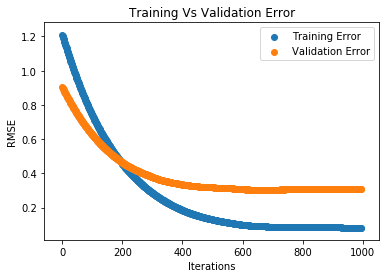

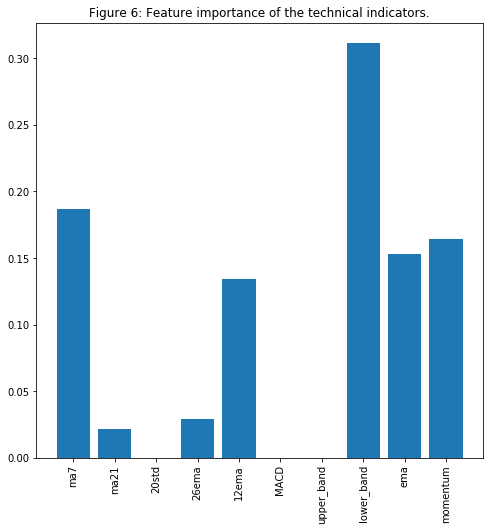

In [87]:
#Using Optuna
import optuna
import functools
study = optuna.create_study()
study.optimize(opt,n_trials=100)
# study.best_params
regressor = xgb.XGBRegressor(**study.best_params)
xgbModel = regressor.fit(X_train_FI,y_train_FI, \
                         eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], \
                         verbose=False)
eval_result = regressor.evals_result()
training_rounds = range(len(eval_result['validation_0']['rmse']))

#Validation Graph
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

#bar graph
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show()

In [84]:
study.best_params

{'colsample_bytree': 0.9,
 'eval_metric': 'rmse',
 'gamma': 0,
 'learning_rate': 0.057683371958262966,
 'max_depth': 1,
 'min_child_weight': 20,
 'n_estimators': 0,
 'optimizer': 'Adam',
 'scale_pos_weight': 70,
 'subsample': 0.7}

In [0]:
regressor = xgb.XGBRegressor(**study.best_params)

[12:41:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


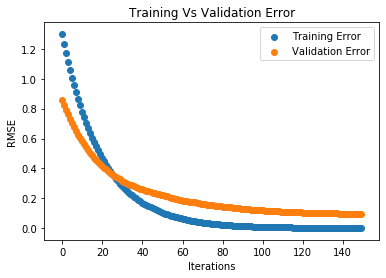

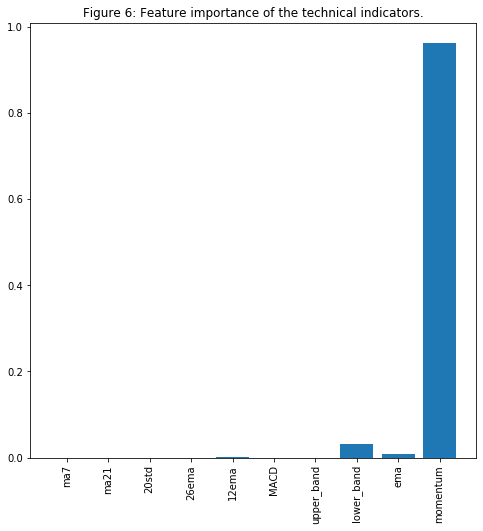

In [90]:
#using Xgboost Without optuna
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)
xgbModel = regressor.fit(X_train_FI,y_train_FI, \
                         eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], \
                         verbose=False)

eval_result = regressor.evals_result()
training_rounds = range(len(eval_result['validation_0']['rmse']))

#validation graph
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

#Bar graph
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show()